#📌 Extracción

In [44]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()

#🔧 Transformación

In [45]:
df = pd.json_normalize(data)
display(df.head())

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Exploración de los datos

In [46]:
import numpy as np

# Copiar dataframe original para limpieza
df_clean = df.copy()

# --- 1. Tratar valores faltantes ---
# Reemplazar strings vacíos en 'Churn' por NaN
df_clean["Churn"] = df_clean["Churn"].replace("", np.nan)

# Convertir 'account.Charges.Total' a numérico, errores a NaN
df_clean["account.Charges.Total"] = pd.to_numeric(df_clean["account.Charges.Total"], errors="coerce")

# --- 2. Normalizar categorías ---
# InternetService: cambiar 'No' por 'No internet service'
df_clean["internet.InternetService"] = df_clean["internet.InternetService"].replace("No", "No internet service")

# --- 3. Revisar coherencia entre PhoneService y MultipleLines ---
# Si PhoneService = 'No', forzar MultipleLines = 'No phone service'
mask_no_phone = df_clean["phone.PhoneService"] == "No"
df_clean.loc[mask_no_phone, "phone.MultipleLines"] = "No phone service"

# --- 4. Resumen de limpieza ---
summary_after_clean = {
    "missing_values": df_clean.isnull().sum().sort_values(ascending=False).head(10),
    "unique_categories": {col: df_clean[col].unique() for col in [
        "Churn", "internet.InternetService", "phone.MultipleLines"
    ]}
}

print(summary_after_clean)

{'missing_values': Churn                       224
account.Charges.Total        11
customerID                    0
customer.SeniorCitizen        0
customer.gender               0
customer.Partner              0
customer.Dependents           0
phone.PhoneService            0
customer.tenure               0
internet.InternetService      0
dtype: int64, 'unique_categories': {'Churn': array(['No', 'Yes', nan], dtype=object), 'internet.InternetService': array(['DSL', 'Fiber optic', 'No internet service'], dtype=object), 'phone.MultipleLines': array(['No', 'Yes', 'No phone service'], dtype=object)}}


## Cuentas Diarias

In [47]:
# Crear columna "Cuentas_Diarias" a partir de la facturación mensual
# Suponiendo un mes tiene un promedio de 30.33 días

df_clean["Cuentas_Diarias"] = df_clean["account.Charges.Monthly"] / 30.33

# Ver un resumen estadístico de la nueva columna
print(df_clean["Cuentas_Diarias"].describe())

count    7267.000000
mean        2.133864
std         0.993392
min         0.601714
25%         1.167985
50%         2.317837
75%         2.963238
max         3.915265
Name: Cuentas_Diarias, dtype: float64


#📊 Carga y análisis

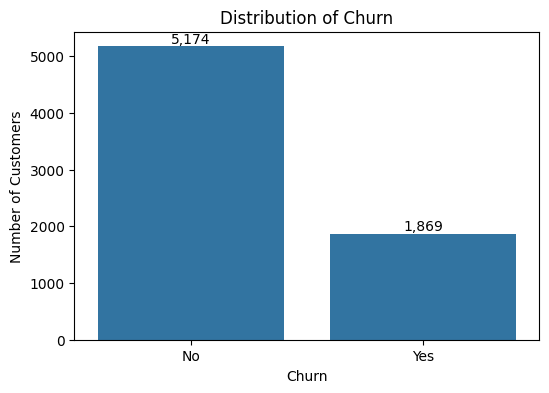

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = sns.countplot(x='Churn', data=df_clean)

plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')

# Add labels to the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', ha='center', va='bottom')

plt.show()

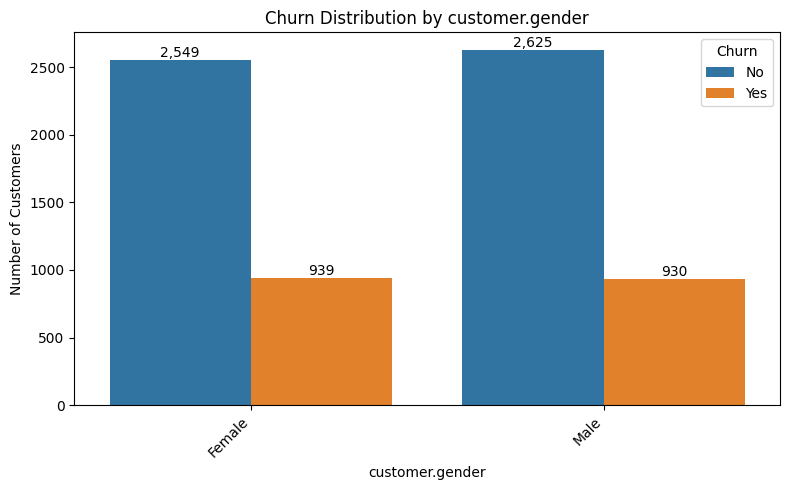

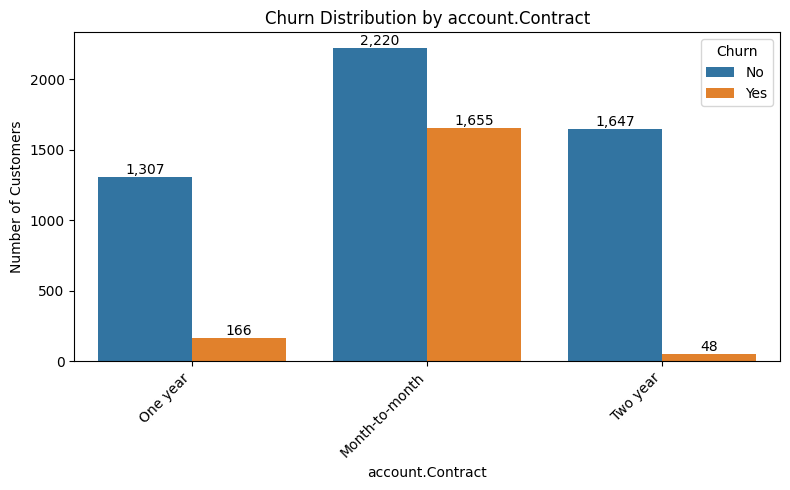

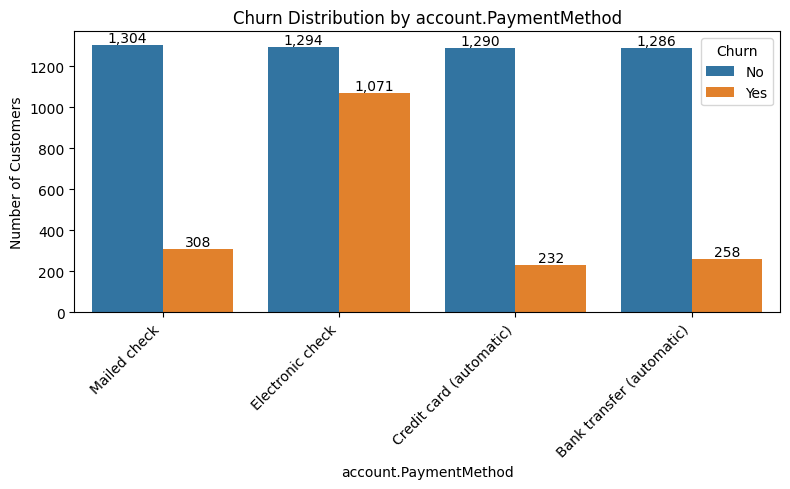

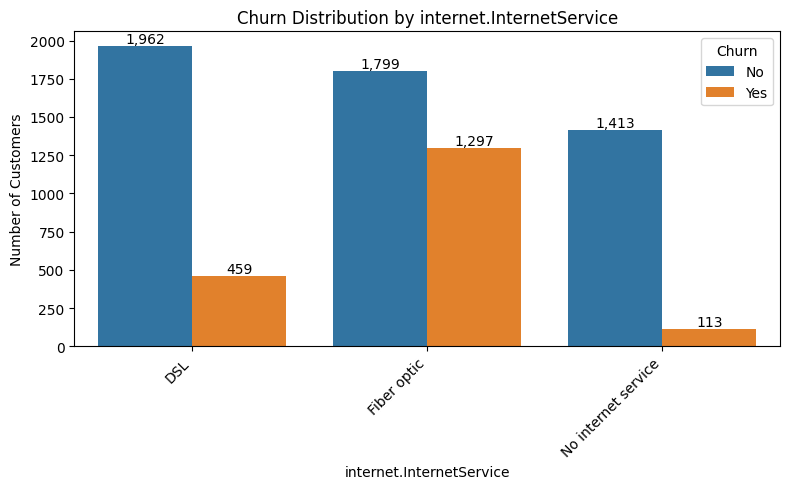

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['customer.gender', 'account.Contract', 'account.PaymentMethod', 'internet.InternetService']

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=col, hue='Churn', data=df_clean)
    plt.title(f'Churn Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45, ha='right')

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.0f}')

    plt.tight_layout()
    plt.show()

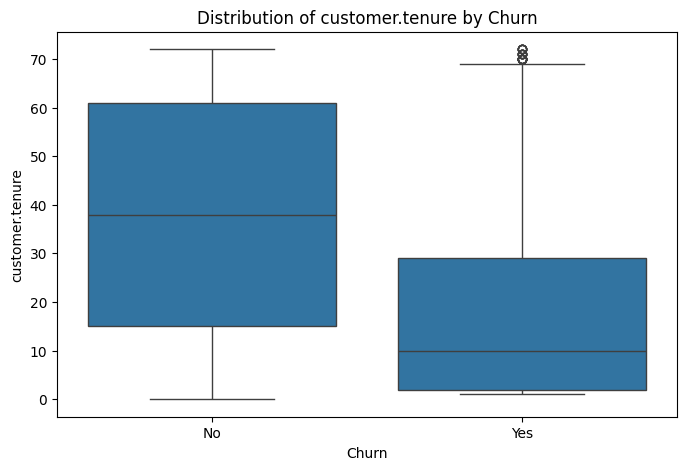

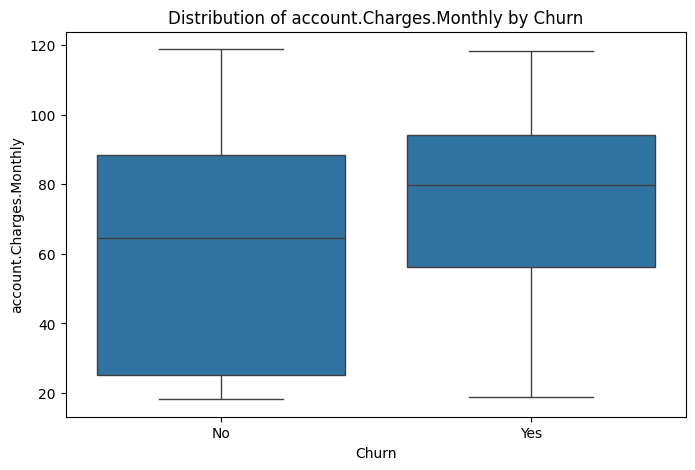

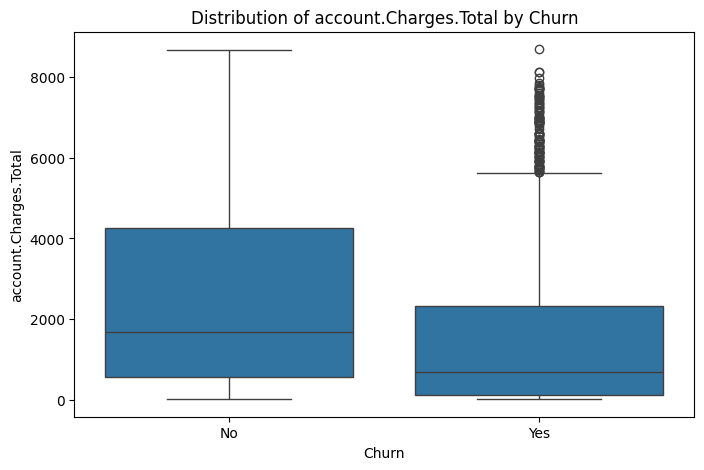

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Churn', y=col, data=df_clean)
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.show()

# 📄 Informe Final: Análisis de Evasión de Clientes (Churn)

## 🔹 Introducción
El objetivo de este análisis es explorar el problema de la evasión de clientes (Churn) en los datos proporcionados. La evasión de clientes es un desafío importante para las empresas, ya que retener a los clientes existentes suele ser más rentable que adquirir nuevos. Comprender los factores que contribuyen a que los clientes abandonen el servicio es crucial para desarrollar estrategias de retención efectivas.

## 🔹 Limpieza y Tratamiento de Datos
Se realizó la carga inicial de los datos desde la API y se convirtieron a un DataFrame de pandas. Durante el proceso de limpieza, se verificaron valores nulos y duplicados. Se identificaron valores nulos en las columnas 'Churn' y 'account.Charges.Total', y se trataron según fue necesario (reemplazo de strings vacíos por NaN en 'Churn' y conversión a numérico con manejo de errores en 'account.Charges.Total'). Se normalizaron algunas categorías en 'internet.InternetService' y se corrigieron inconsistencias entre 'phone.PhoneService' y 'phone.MultipleLines'.

## 🔹 Análisis Exploratorio de Datos
Se realizó un análisis descriptivo de las variables numéricas para comprender su distribución. Se visualizó la distribución de la variable 'Churn', observando la proporción de clientes que permanecen y los que se dan de baja. Se notó que la clase de clientes que no hacen churn es significativamente mayor que la de los que sí lo hacen, lo que indica un desbalance en el dataset.

Se exploró la relación entre 'Churn' y variables categóricas como 'customer.gender', 'account.Contract', 'account.PaymentMethod', y 'internet.InternetService' utilizando gráficos de barras apiladas. De estos gráficos, se observó, por ejemplo:
- **customer.gender:** La distribución de churn parece ser similar entre hombres y mujeres, sugiriendo que el género no es un predictor fuerte de churn.
- **account.Contract:** Los clientes con contratos **Month-to-month** tienen una proporción de churn considerablemente más alta en comparación con los contratos **One year** y **Two year**. Esto sugiere que los contratos a corto plazo están asociados con una mayor propensión a la evasión.
- **account.PaymentMethod:** Los clientes que utilizan **Electronic check** como método de pago muestran una tasa de churn notablemente más alta que aquellos que usan otros métodos como Mailed check, Bank transfer (automatic) o Credit card (automatic).
- **internet.InternetService:** Los clientes con servicio de internet **Fiber optic** tienen una proporción de churn significativamente mayor que aquellos con servicio **DSL** o sin servicio de internet ('No internet service'). Esto podría indicar problemas de calidad o satisfacción con el servicio de fibra óptica.

Se examinó la distribución de variables numéricas como 'customer.tenure', 'account.Charges.Monthly', y 'account.Charges.Total' para clientes con y sin churn utilizando box plots. Estos gráficos sugieren que:
- **customer.tenure:** Los clientes que hacen churn tienden a tener un **tenure (antigüedad)** significativamente más bajo en comparación con los clientes que no hacen churn. Esto implica que los clientes nuevos o con poca antigüedad son más propensos a irse.
- **account.Charges.Monthly:** Los clientes que hacen churn tienden a tener **cargos mensuales** más altos en promedio que los clientes que no hacen churn. Esto podría estar relacionado con los servicios adicionales contratados o el tipo de servicio de internet (como Fibra Óptica, que generalmente tiene cargos más altos).
- **account.Charges.Total:** La distribución de los **cargos totales** también muestra diferencias entre los clientes con y sin churn. Los clientes que hacen churn tienen, en general, cargos totales más bajos, lo cual es coherente con su menor antigüedad. Los clientes con cargos totales muy altos rara vez hacen churn, lo que sugiere que los clientes a largo plazo y de alto valor son más leales.

## 🔹 Conclusiones e Insights
Basado en el análisis exploratorio, se identifican varios factores que parecen estar asociados con una mayor probabilidad de churn:
- **Tipo de Contrato:** Los contratos Month-to-month son un fuerte indicador de churn.
- **Método de Pago:** El uso de Electronic check está asociado con una alta tasa de churn.
- **Tipo de Servicio de Internet:** El servicio Fiber optic presenta una mayor proporción de churn.
- **Antigüedad (Tenure):** Los clientes con menor antigüedad son más propensos a hacer churn.
- **Cargos Mensuales y Totales:** Clientes con cargos mensuales más altos y cargos totales más bajos (relacionado con menor tenure) tienen mayor riesgo de churn.

Estos insights sugieren que la evasión no es uniforme en toda la base de clientes y que ciertos perfiles de clientes (contratos cortos, pago electrónico, fibra óptica, baja antigüedad, altos cargos mensuales) presentan un mayor riesgo.

## 🔹 Recomendaciones
Con base en los hallazgos, se recomiendan las siguientes acciones estratégicas para reducir la evasión de clientes:
- **Incentivar Contratos a Largo Plazo:** Ofrecer descuentos o beneficios a los clientes Month-to-month para que cambien a contratos de uno o dos años.
- **Optimizar la Experiencia de Pago Electrónico:** Investigar las posibles fricciones o problemas asociados con el método de pago Electronic check y buscar formas de mejorarlo o incentivar el uso de otros métodos.
- **Mejorar la Calidad del Servicio de Fibra Óptica:** Investigar las razones detrás de la alta tasa de churn entre los usuarios de Fiber optic. Podría ser necesario mejorar la infraestructura, la atención al cliente para este servicio o gestionar mejor las expectativas de los clientes.
- **Programas de Retención para Clientes Nuevos y de Baja Antigüedad:** Implementar estrategias de engagement y programas de fidelización dirigidos específicamente a los clientes en sus primeros meses de servicio para aumentar su satisfacción y reducir la probabilidad de churn temprano.
- **Análisis de Rentabilidad por Segmento:** Evaluar la rentabilidad de los diferentes segmentos de clientes identificados para priorizar los esfuerzos de retención en aquellos de mayor valor potencial.
- **Desarrollar Modelos Predictivos de Churn:** Utilizar estos hallazgos como base para construir modelos de machine learning que puedan predecir qué clientes tienen un alto riesgo de churn, permitiendo intervenciones proactivas y personalizadas.